In [1]:
import sys
sys.path.append("..")

# Car Tracking Example

Track car state with Kalman filter and Rauch-Tung-Striebel
smoother as in Examples 6.8 and 12.4 of the book

_Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed., Cambridge University Press._

See LICENSE provided with the software.

## Imports

### Standard imports

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy.special import erfcinv
import warnings

### Helpers imports

In [3]:
def _atleast2d(*args):
    return tuple(np.atleast_2d(elem) for elem in args)

def generate_ssm(m_0, A, Q, H, R, steps, random_state):
    """Samples from a state space model given parameters and a random state

    Parameters
    ----------
    m_0 : (M,) array_like
        Initial mean of the state
    P_0 : (M, M) array_like
        Initial covariance of the state
    A : (M, M) or (M, M) array_like
        Transition matrix
    Q : (M, M) array_like
        Transition covariance
    H : (M, N) array_like
        Observation matrix
    R : (N, N) array_like
        Observation covariance
    steps : int
        Number of steps simulated
    random_state : RandomState
        Random state used for pseudo-random numbers generation

    Returns
    -------
    states : (steps, M) ndarray
        The true states
    observations : (steps, N) ndarray
        The noisy observations

    Examples
    --------
    >>> M, N = 2, 1
    >>> m_0 = np.zeros(M)
    >>> P_0 = Q  = [[0.4, -0.2],
    ...             [-0.2, 0.5]]
    >>> A = np.zeros((M, M))
    >>> H = [0., 0.]
    >>> R = 0.5
    >>> states, observations = generate_ssm(m_0, P_0, A, Q, H, R, 10000, RandomState(5))
    >>> est_cov = np.cov(states, rowvar=False)
    >>> est_error = np.cov(observations, rowvar=False)
    >>> cov_close = np.allclose(est_cov, Q, atol=1e-2)
    >>> error_close = np.allclose(est_error, R, atol=1e-2)
    >>> cov_close & error_close
    True
    """
    if not isinstance(random_state, RandomState):
        raise TypeError(f"random_state must be an instance of {RandomState}, "
                        f"'{random_state}' of type '{type(random_state)}' was given")

    m_0 = np.atleast_1d(m_0)
    A, Q, H, R = _atleast2d(A, Q, H, R)

    M = m_0.shape[-1]
    N = R.shape[-1]
    states = np.empty((steps, M))
    observations = np.empty((steps, N))

    chol_Q = np.linalg.cholesky(Q)
    chol_R = np.linalg.cholesky(R)

    state = m_0
    for i in range(steps):
        state = A @ state + chol_Q @ random_state.randn(M)
        states[i, :] = state
        obs = H @ state + chol_R @ random_state.randn(N)
        observations[i, :] = obs

    return states, observations


def plot_car_trajectory(y, x1, label1, x2=None, label2=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(y[:, 0], y[:, 1], marker="o", label="Measurements", color="red")
    ax.plot(x1[:, 0], x1[:, 1], label=label1, color="blue")
    if x2 is None:
        ax.scatter(x1[0, 0], x1[0, 1], marker="x", color="orange", s=500)
    else:
        ax.plot(x2[:, 0], x2[:, 1], label=label2, color="orange")
    _ = ax.legend()
    _ = ax.set_xlabel("${\it x}_1$")
    _ = ax.set_ylabel("${\it x}_2$")
    
def rmse(x, y):
    """Computes the RMSE between x and y along all their dimensions, x and y must have the same dimensions.

        Parameters
        ----------
        x : (L,...) array_like
            Initial mean of the state
        y : (L, ...) array_like
            Initial covariance of the state

        Returns
        -------
        out : float
            The RMSE
    """
    return np.sqrt(np.mean(np.sum(np.square(x - y), -1)))

import numpy.random as rd

SQRT_2 = 2 ** 0.5


class RandomState(rd.RandomState):
    """Enforces MT1997 and reproducibility with Matlab"""

    def __init__(self, seed=0):
        if not isinstance(seed, int):
            raise TypeError(f"seed must be an int, '{seed}' of type '{type(seed)}' was passed")
        super(RandomState, self).__init__(seed)

    def randn(self, *args):
        if args:
            uniforms = self.rand(*args[::-1]).T
        else:
            uniforms = self.rand()
        return SQRT_2 * erfcinv(2 * uniforms)

    def choice(self, n, k, p=None):
        if p is None:
            p = np.full(n, 1/n)
        cs = np.cumsum(p)
        cs = cs / cs[-1]
        uniforms = self.rand(k)
        return np.searchsorted(cs, uniforms, "left")

## Routine

Set the parameters:

In [4]:
q = 1.
dt = 0.1
s = 0.5

M = 4  # State dimension
N = 2  # Observation dimension

In [5]:
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

In [6]:
Q = q * np.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0],
                  [0, dt **3 / 3, 0, dt ** 2 / 2],
                  [dt ** 2 / 2, 0, dt, 0],
                  [0, dt ** 2 / 2, 0, dt]])

In [7]:
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

In [8]:
R = np.array([[s ** 2, 0],
              [0, s ** 2]])

In [9]:
x_0 = np.array([0., 0., 1., -1.])

## Simulate data

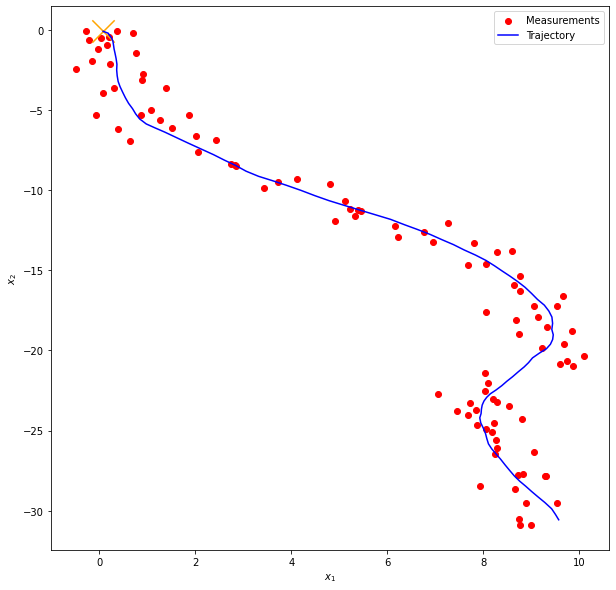

In [10]:
random_state = RandomState(6)
steps = 100

states, observations = generate_ssm(x_0, A, Q, H, R, steps, random_state)

plot_car_trajectory(observations, states, "Trajectory")

## Kalman Filter

In [11]:
def kalman_filter(m_0, P_0, A, Q, H, R, observations):
    M = m_0.shape[-1]
    steps, N = observations.shape
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    
    m = m_0
    P = P_0
    
    for i in range(steps):
        y = observations[i]
        m = A @ m
        P = A @ P @ A.T + Q
        
        S = H @ P @ H.T + R
        # More efficient and stable way of computing K = P @ H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a positive definite matrix (assume_a="pos")
        K = linalg.solve(S.T, H @ P, assume_a="pos").T 
        
            
        m = m + K @ (y - H @ m)
        P = P - K @ S @ K.T
        
        kf_m[i] = m
        kf_P[i] = P
    return kf_m, kf_P

RAW RMSE: 0.7131995943918173
KF RMSE: 0.3746597043548559


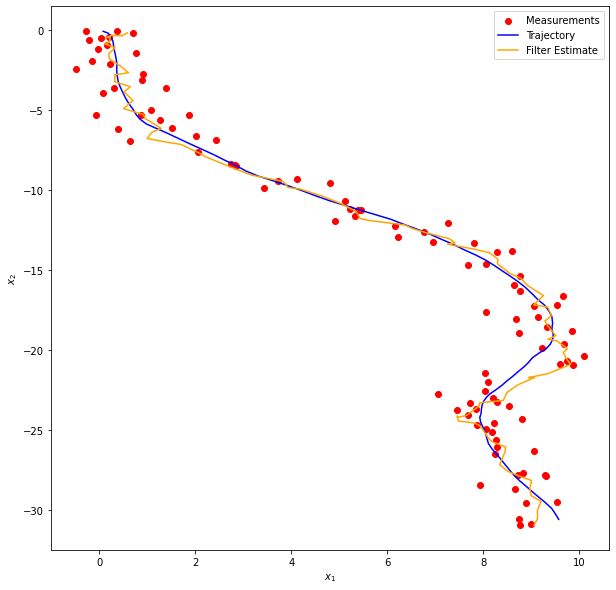

In [12]:
m_0 = x_0
P_0 = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

kf_m, kf_P = kalman_filter(m_0, P_0, A, Q, H, R, observations)

plot_car_trajectory(observations, states, "Trajectory", kf_m, "Filter Estimate")

rmse_raw = rmse(states[:, :2], observations)
rmse_kf = rmse(kf_m[:, :2], states[:, :2])
print(f"RAW RMSE: {rmse_raw}")
print(f"KF RMSE: {rmse_kf}")

## RTS Smoother

In [13]:
def rts_smoother(kf_m, kf_P, A, Q):
    steps, M = kf_m.shape
    
    rts_m = np.empty((steps, M))
    rts_P = np.empty((steps, M, M))
    
    m = kf_m[-1]
    P = kf_P[-1]
    
    rts_m[-1] = m
    rts_P[-1] = P
    
    for i in range(steps-2, -1, -1):
        filtered_m = kf_m[i]
        filtered_P = kf_P[i]
        
        mp = A @ filtered_m
        Pp = A @ filtered_P @ A.T + Q

        # More efficient and stable way of computing Gk = filtered_P @ A.T @ linalg.inv(Pp)
        # This also leverages the fact that Pp is known to be a positive definite matrix (assume_a="pos")
        Gk = linalg.solve(Pp, A @ filtered_P, assume_a="pos").T 
       
            
        m = filtered_m + Gk @ (m - mp)
        P = filtered_P + Gk @ (P - Pp) @ Gk.T
        
        rts_m[i] = m
        rts_P[i] = P

    return rts_m, rts_P

RTS RMSE: 0.18573322321869157


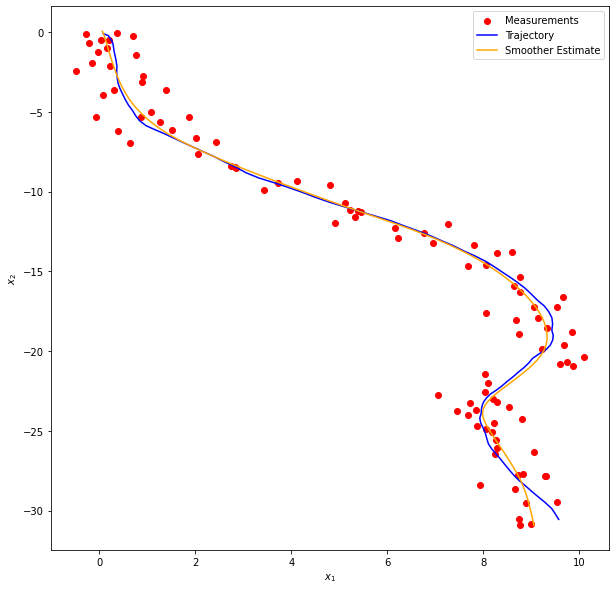

In [14]:
rts_m, rts_P = rts_smoother(kf_m, kf_P, A, Q)

plot_car_trajectory(observations, states, "Trajectory", rts_m, "Smoother Estimate")

rmse_rts = rmse(states[:, :2], rts_m[:, :2])
print(f"RTS RMSE: {rmse_rts}")

# Nonlinear Smoother

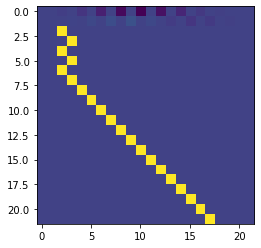

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1.]), array([[ 1.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000],
       [ 0.00000000e+000,  1.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,


In [87]:
def Bmat(n, p, taps):
    assert(len(taps)>=5)
    I = np.eye(n)
    b = np.array([0] + taps + [0]*(p-len(taps)))

    brow = []
    for bi in b:
        brow.append(bi*I)
    brow = np.array(brow).reshape((p+1)*n,n).T

    B1 = []
    for i in range(0, p*n, n):
        if i > 0:
            B1.append(np.concatenate([np.array(list(np.zeros((n, n)))*(i//2)).T, brow[:, :-i]], axis=1))
        else:
            B1.append(brow)

    B1 = np.array(B1).reshape(p*n, (p+1)*n)

    ###########
    b = np.array([0] + [1,0,0,0,0] + [0]*(p-5))

    brow = []
    for bi in b:
        brow.append(bi*I)
    brow = np.array(brow).reshape((p+1)*n,n).T

    B2 = []
    for i in range(0, p*n, n):
        if i > 0:
            B2.append(np.concatenate([np.array(list(np.zeros((n, n)))*(i//2)).T, brow[:, :-i]], axis=1))
        else:
            B2.append(brow)

    B2 = np.array(B2).reshape(p*n, (p+1)*n)

    B = np.concatenate([B1, B2], axis=0)
#     plt.imshow(B) 
#     plt.show()
    return B

def selmat(n, p):
    S = np.eye(p*n, p*n)
    S = np.concatenate([S, np.zeros((p*n, p*n))], axis=1)
    S = np.concatenate([S, np.zeros((p*n, 2*p*n))], axis=0)
#     plt.imshow(S)
#     plt.show()
    return S

def bias_selmat(n, p):
    b = np.concatenate([np.zeros((p*n, 1)), np.ones((p*n, 1))], axis=0)
#     plt.imshow(b)
#     plt.show()
    return b

def Lmat(n, p, taps):
    I_l = np.eye(p*n, p*n)
    L = np.concatenate([np.zeros((p*n, p*n)), I_l], axis=1)
    
    trow = []
    l = np.array(taps + [0]*(p-len(taps)))

    for li in l:
        trow.append(li*np.eye(n, n))

    trow = np.array(trow).reshape(p*n,n).T
    trow = np.concatenate([trow, np.zeros((n, n*p))], axis=1)
    
    L = np.concatenate([trow, L], axis=0)
#     plt.imshow(L)
#     plt.show()
    return L

def A_identity(n, p):
    I_l = np.eye((p-1)*n, (p-1)*n)
    I_l = np.concatenate([np.zeros(((p-1)*n, n)), I_l, np.zeros(((p-1)*n, n))], axis=1)
#     I_u = np.eye(2*n, 2*n)
#     I_u = np.concatenate([I_u, np.zeros((2*n, (p-1)*n))], axis=1)
    A_block = np.eye(n, n*p)
#     A_block[0,0] = 0
#     A_block[1,1] = 0
#     A_block[0,4] = 1
#     A_block[1,5] = 1

    connections = np.concatenate([np.zeros((n, n)), A_block], axis=1)
#     print(connections.shape)
    I_u = np.concatenate([np.eye(n, n*(p+1)), connections], axis=0)
    A = np.concatenate([I_u, I_l], axis=0)
#     plt.imshow(A)
#     plt.show()
    return A

def f(x):
    B = Bmat(2, 10, [1/9,2/9,3/9,2/9,1/9])
    S = selmat(2, 10)
    b = bias_selmat(2, 10)
    L = Lmat(2, 10, [1/9,2/9,3/9,2/9,1/9])
    A = A_identity(2, 10)
    
    return np.dot(A, L@np.diag(np.ravel(S@B@x + b))@(B@x))

def F_x(x):
    B = Bmat(2, 10, [1/9,2/9,3/9,2/9,1/9])
    S = selmat(2, 10)
    b = bias_selmat(2, 10)
    L = Lmat(2, 10, [1/9,2/9,3/9,2/9,1/9])
    A = A_identity(2, 10)
    return np.dot(A, L@np.diag(np.ravel(B@x))@S@B + A@L@np.diag(np.ravel(S@B@x + b))@B)

def G(x):
    B = Bmat(2, 10, [1/9,2/9,3/9,2/9,1/9])
    S = selmat(2, 10)
    b = bias_selmat(2, 10)
    L = Lmat(2, 10, [1/9,2/9,3/9,2/9,1/9])
    return L@np.diag(np.ravel(B@x))@S@B + L@np.diag(np.ravel(S@B@x + b))@B

def g(x):
    B = Bmat(2, 10, [1/9,2/9,3/9,2/9,1/9])
    S = selmat(2, 10)
    b = bias_selmat(2, 10)
    L = Lmat(2, 10, [1/9,2/9,3/9,2/9,1/9])
    A = A_identity(2, 10)
    
    return L@np.diag(np.ravel(S@B@x + b))@(B@x)


    
B = Bmat(2, 10, [1/9,2/9,3/9,2/9,1/9])
S = selmat(2, 10)
b = bias_selmat(2, 10)
L = Lmat(2, 10, [1/9,2/9,3/9,2/9,1/9])
A = A_identity(2, 10)

x = np.random.standard_normal((22,1))
F_x(x).shape, f(x).shape, x.shape

plt.imshow(F_x(x))
plt.show()
print(np.linalg.eig(A))

In [88]:
def generate_nonlinear_ssm(m_0, P_0, f, Q, H, R, steps, random_state):
    """Samples from a state space model given parameters and a random state

    Parameters
    ----------
    m_0 : (M,) array_like
        Initial mean of the state
    P_0 : (M, M) array_like
        Initial covariance of the state
    f : function
        nonlinearity
    Q : (M, M) array_like
        Transition covariance
    H : (M, N) array_like
        Observation matrix
    R : (N, N) array_like
        Observation covariance
    steps : int
        Number of steps simulated
    random_state : RandomState
        Random state used for pseudo-random numbers generation

    Returns
    -------
    states : (steps, M) ndarray
        The true states
    observations : (steps, N) ndarray
        The noisy observations
    """
    if not isinstance(random_state, RandomState):
        raise TypeError(f"random_state must be an instance of {RandomState}, "
                        f"'{random_state}' of type '{type(random_state)}' was given")

    m_0 = np.atleast_1d(m_0)
    Q, H, R = _atleast2d(Q, H, R)

    M = m_0.shape[0]
    N = R.shape[-1]
    states = np.empty((steps, M))
    observations = np.empty((steps, N))

    chol_Q = np.linalg.cholesky(Q)
    chol_R = np.linalg.cholesky(R)

    state = m_0
    for i in range(steps):
        print("step", i)
        state = f(state) + (chol_Q @ random_state.randn(M))[:, np.newaxis]
        
        states[i, :] = np.ravel(state)
        obs = H @ state + (chol_R @ random_state.randn(N))[:, np.newaxis]
        observations[i, :] = np.ravel(obs)

    return states, observations

def extended_kalman_filter(m_0, P_0, f, F, Q, H, R, observations):
    M = m_0.shape[0]
    steps, N = observations.shape
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    
    m = m_0
    P = P_0
    
    for i in range(steps):
        y = observations[i][:, np.newaxis]
        m = f(m)
        P = F(m) @ P @ F(m).T + Q
        
        S = H @ P @ H.T + R
        # More efficient and stable way of computing K = P @ H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a positive definite matrix (assume_a="pos")
        try:
            K = linalg.solve(S.T, H @ P, assume_a="pos").T 
        except linalg.LinAlgError:
            print("Exact solution not found (likely filter tried to invert singular matrix). Attempting least squares solution")
            K, *rest = linalg.lstsq(S.T, H @ P)
            K = K.T
            
        m = m + K @ (y - H @ m)
        P = P - K @ S @ K.T
        
        kf_m[i] = np.ravel(m)
        kf_P[i] = P
    return kf_m, kf_P

def extended_rts_smoother(kf_m, kf_P, f, F, Q):
    def fmt(f, x):
        x = x[:, np.newaxis]
        y = f(x)
        return y

    steps, M = kf_m.shape
    
    rts_m = np.empty((steps, M))
    rts_P = np.empty((steps, M, M))
    
    m = kf_m[-1]
    P = kf_P[-1]
    
    rts_m[-1] = m
    rts_P[-1] = P
    
    for i in range(steps-2, -1, -1):
        filtered_m = kf_m[i]
        filtered_P = kf_P[i]
        
        mp = fmt(f, filtered_m)
        Pp = fmt(F, filtered_m) @ filtered_P @ fmt(F, filtered_m).T + Q
        
        # More efficient and stable way of computing Gk = filtered_P @ A.T @ linalg.inv(Pp)
        # This also leverages the fact that Pp is known to be a positive definite matrix (assume_a="pos")
        try:
            Gk = linalg.solve(Pp, fmt(F, filtered_m) @ filtered_P, assume_a="pos").T 
        except linalg.LinAlgError:
            print("Exact solution not found (likely smoother tried to invert singular matrix). Attempting least squares solution")
            Gk, *rest = linalg.lstsq(Pp, fmt(F, filtered_m) @ filtered_P)
            Gk = Gk.T
            
        m = filtered_m + Gk @ (m - np.ravel(mp))
        P = filtered_P + Gk @ (P - Pp) @ Gk.T
                
        rts_m[i] = np.ravel(m)
        rts_P[i] = P

    return rts_m, rts_P



In [89]:
n = 2
p = 10
pn_coeff = 5
on_coeff = 1000

x_0 = np.random.standard_normal(((p+1)*n, 1))
P_0 = Q = 0.001* np.eye((p+1)*n, (p+1)*n)
P_0[n, n] = pn_coeff
P_0[n+1, n+1] = pn_coeff
Q[n, n] = pn_coeff
Q[n+1, n+1] = pn_coeff



H = np.zeros((2, (p+1)*n))
H[0, 0] = 1
H[1, 1] = 1

R = on_coeff*np.eye(n)

random_state = RandomState(12)
steps = 1000

states, observations = generate_nonlinear_ssm(x_0, P_0, f, Q, H, R, steps, random_state)

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85
step 86
step 87
step 88
step 89
step 90
step 91
step 92
step 93
step 94
step 95
step 96
step 97
step 98
step 99
step 100
step 101
step 102
step 103
step 104
step 105
step 106
step 107
step 108
step 109
step 110
step 111
step 112
step 113
step 114
step 115
step 116
step 117
step 118
step 119
step 120
step 121
step 122
ste

step 988
step 989
step 990
step 991
step 992
step 993
step 994
step 995
step 996
step 997
step 998
step 999


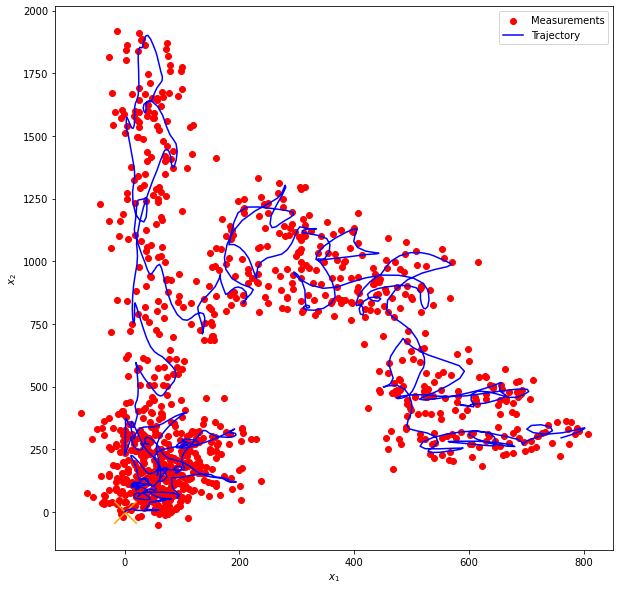

In [69]:
plot_car_trajectory(observations, states, "Trajectory")

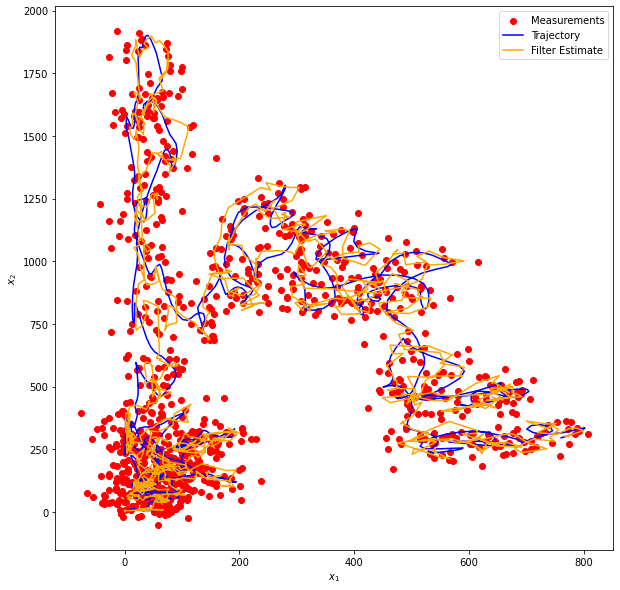

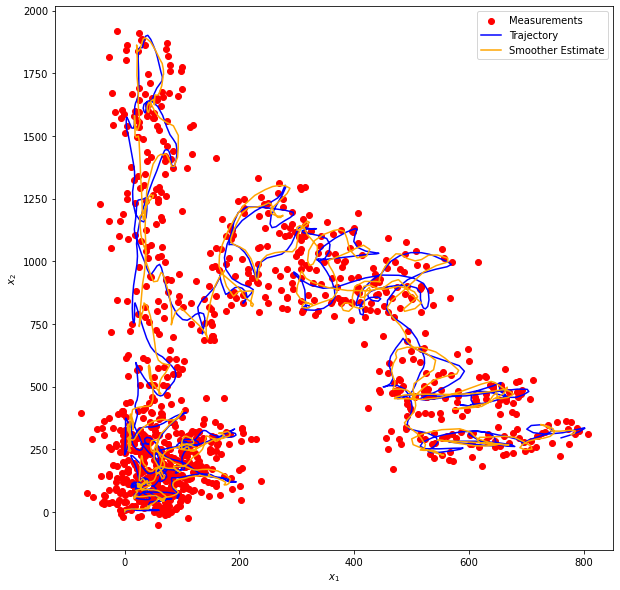

In [70]:
m_0 = np.random.standard_normal(((p+1)*n, 1))
P_0 = np.eye((p+1)*n, (p+1)*n)

kf_m, kf_P = extended_kalman_filter(m_0, P_0, f, F_x, Q, H, R, observations)


plot_car_trajectory(observations, states, "Trajectory", kf_m, "Filter Estimate")

s_m, s_P = extended_rts_smoother(kf_m, kf_P, f, F_x, Q)
plot_car_trajectory(observations, states, "Trajectory", s_m, "Smoother Estimate")


step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85
step 86
step 87
step 88
step 89
step 90
step 91
step 92
step 93
step 94
step 95
step 96
step 97
step 98
step 99
step 100
step 101
step 102
step 103
step 104
step 105
step 106
step 107
step 108
step 109
step 110
step 111
step 112
step 113
step 114
step 115
step 116
step 117
step 118
step 119
step 120
step 121
step 122
ste

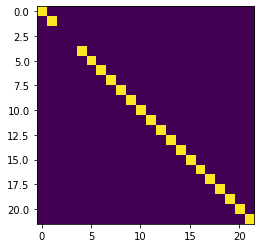

e step
m step


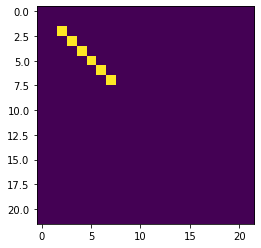

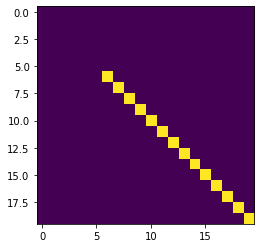

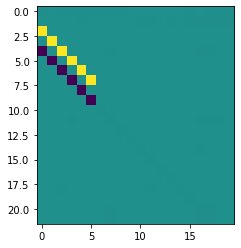

combined


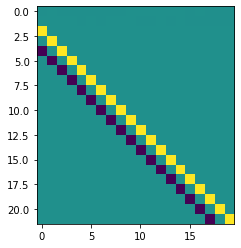

[[-7.21857652e-09 -1.37579062e-20 -2.05244378e-08 -5.39357418e-15
  -3.25091595e-08 -4.26907629e-15 -2.76019216e-08 -5.21950344e-11
  -5.57671850e-09  1.84384505e-11  1.37702689e-08  2.97362515e-11
   2.10406908e-08  1.64862529e-11  1.23294933e-08 -1.59815457e-11
   4.86144456e-09 -4.57714800e-11 -2.59398707e-11 -1.11619980e-11]
 [-1.61224803e-20  1.58921389e-08  1.51553383e-14  5.66648046e-08
  -5.40442055e-16  9.61427208e-08 -9.39007312e-13  8.95834939e-08
   1.44371299e-11  2.96019527e-08 -3.06516131e-11 -2.78900039e-08
   1.30536740e-11 -4.12012443e-08  1.13794978e-11 -2.19280972e-08
  -1.21681578e-10 -3.94520039e-09 -4.36893141e-11 -1.87996325e-11]
 [ 1.00000000e+00  1.64168352e-38 -1.74512794e-32  4.69841055e-33
   8.80951502e-34 -2.29005652e-33  1.20297539e-30  1.24369880e-28
   2.25544965e-29  4.98467317e-29  4.17528339e-29 -6.65276962e-29
   2.45778667e-29 -4.46150968e-29 -2.81320537e-30  3.49419802e-29
  -1.10549416e-29  2.70460577e-29  4.28382698e-29 -1.55956511e-29]
 [ 1.64

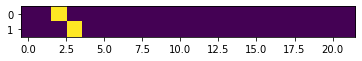

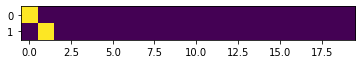

<Figure size 432x288 with 0 Axes>

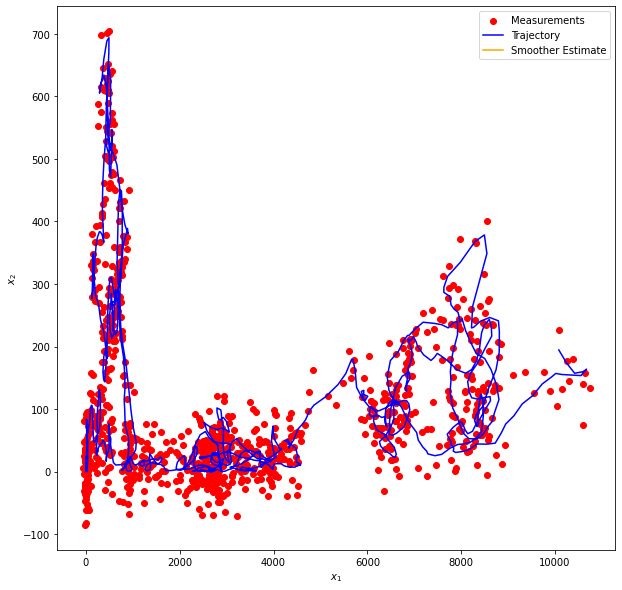

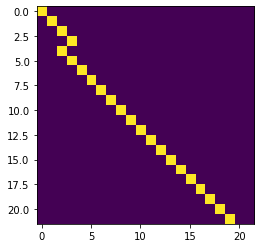

1


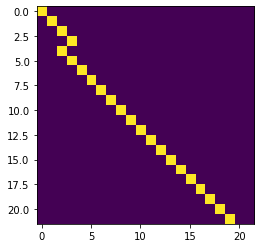

e step
m step


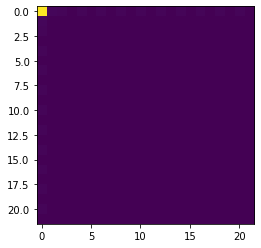

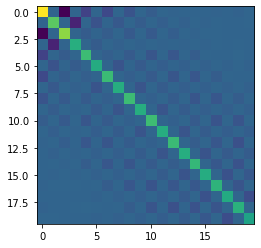

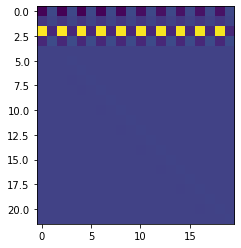

combined


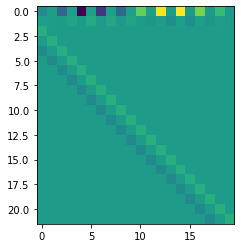

[[-9.52655594e-01  1.08311209e-01 -2.92565253e+00  3.40751254e-02
  -7.47592576e+00  1.90502818e-01 -5.43097291e+00  1.50655688e-01
  -2.97293321e+00  1.40075907e-01  2.84418433e+00  9.46434003e-02
   5.78306225e+00  1.06588681e-03  6.04565368e+00 -1.28397550e-01
   3.33324229e+00 -2.22498226e-01  1.68789063e+00 -2.33874338e-01]
 [ 1.67115370e-01  2.53340761e-02 -4.06149659e-03  3.97588374e-01
  -1.30205442e-01  7.78637253e-01 -2.06901168e-01  6.71723776e-01
  -2.22797595e-01  4.07191828e-01 -1.19406751e-01 -3.42040085e-01
   2.77350200e-02 -7.15814430e-01  1.50157241e-01 -7.24744127e-01
   1.88715002e-01 -3.52328597e-01  1.05069973e-01 -1.73056049e-01]
 [ 1.00000000e+00  1.04083409e-14 -1.55354896e-13 -3.91353616e-15
   1.90125693e-14 -3.33066907e-15  2.26346719e-14 -3.55271368e-15
   9.47679435e-15  2.22044605e-15  6.85285162e-14 -7.10542736e-15
   2.59514632e-14 -8.43769499e-15 -6.35602682e-15 -8.88178420e-16
  -4.35172731e-14  3.55271368e-15 -3.13013504e-14  0.00000000e+00]
 [-2.45

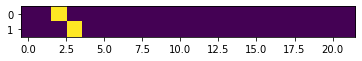

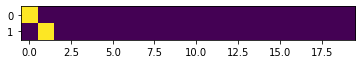

<Figure size 432x288 with 0 Axes>

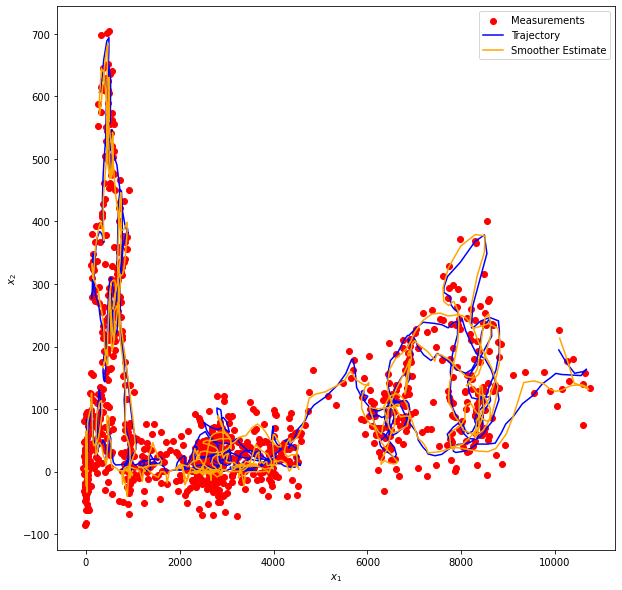

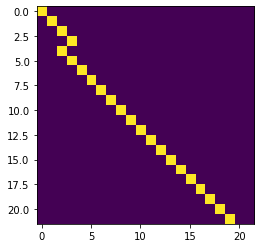

In [71]:
def R_k(m, P):
    R = np.zeros(P.shape)
    for k in range(1, len(kf_m)):
        mk = m[k][:, np.newaxis]    # column vector m_k^s
        mk1 = m[k-1][:, np.newaxis] # column vector m_{k-1}^s
        Pk = P[k]
        
        R[k] = mk@g(mk1).T + (Pk + mk@mk.T)@G(mk1).T - mk@mk1.T@G(mk1).T
    
    return R
        
def S_k(m, P):
    S = np.zeros(P.shape)
    for k in range(1, len(kf_m)):
        mk = m[k][:, np.newaxis]    # column vector m_k^s
        mk1 = m[k-1][:, np.newaxis] # column vector m_{k-1}^s
        Pk = P[k]
        
        S[k] = g(mk1)@g(mk1).T + g(mk1)@mk.T@G(mk1).T - g(mk1)@mk1.T@G(mk1).T + \
               G(mk1)@mk@g(mk1).T - G(mk1)@mk1@g(mk1).T + G(mk1)@(Pk + mk@mk.T)@G(mk1).T -\
               G(mk1)@mk@mk1.T@G(mk1).T - G(mk1)@mk1@mk.T@G(mk1).T + G(mk1)@mk1@mk1.T@G(mk1).T
      
    return S

def e_step(m_0, P_0, A_init, f, F, Q, H, R):
    print("e step")
    kf_m, kf_P = extended_kalman_filter(m_0, P_0, f, F, Q, H, R, observations)

    s_m, s_P = extended_rts_smoother(kf_m, kf_P, f, F, Q)
    return s_m, s_P

def subdivide_A(n, p):
    E_1 = np.concatenate([np.zeros((n,n)), np.eye(n), np.zeros((n*(p-1), n))], axis=0).T
    E_2 = np.concatenate([np.zeros((n*p, n)), np.eye(n*p, n*p)], axis=1)
    Res = np.concatenate([np.eye(n, n*(p+1)), np.zeros((n, n*(p+1))), \
                          np.concatenate([np.zeros((n*(p-1), n)), np.eye(n*(p-1), n*p)], axis=1)], axis=0)
    return E_1, E_2, Res

left = None
right = None
def m_step(m, P):
    global left, right
    print("m step")
    E_1, E_2, Res = subdivide_A(n, p)
    
    R = R_k(m, P)
    S = S_k(m, P)
    R = R.sum(axis=0)
    S = S.sum(axis=0)
    plt.imshow(S)
    plt.show()
    plt.imshow(np.linalg.inv(E_2@S@E_2.T))
    plt.show()
    right = np.linalg.inv(E_2@S@E_2.T)
    plt.imshow(R@E_2.T - Res@S@E_2.T)
    plt.show()
    left = R@E_2.T - Res@S@E_2.T
    print("combined")
    plt.imshow((R@E_2.T - Res@S@E_2.T) @ np.linalg.inv(E_2@S@E_2.T))
    plt.show()
    print((R@E_2.T - Res@S@E_2.T) @ np.linalg.inv(E_2@S@E_2.T))
    plt.imshow(np.linalg.pinv(E_1.T))
    plt.show()
    
    A_block_star = np.linalg.pinv(E_1.T) @ (R - Res@S) @ np.linalg.inv(S) @ np.linalg.pinv(E_2)
    plt.imshow(A_block_star)
    
    # return reconstructed A matrix
    return Res + E_1.T@A_block_star@E_2

# def m_step(m, P):
#     print("m step")
#     R = R_k(m, P)
#     S = S_k(m, P)
    
#     R = R.sum(axis=0)
#     S = S.sum(axis=0)
#     A_star = R @ np.linalg.inv(S)
#     return A_star


n = 2
p = 10
pn_coeff = 5
on_coeff = 1000

x_0 = np.random.standard_normal(((p+1)*n, 1))
P_0 = Q = 0.001* np.eye((p+1)*n, (p+1)*n)
P_0[n, n] = pn_coeff
P_0[n+1, n+1] = pn_coeff
P_0[n+2, n+2] = pn_coeff
P_0[n+3, n+3] = pn_coeff
P_0[n+4, n+4] = pn_coeff
P_0[n+5, n+5] = pn_coeff

Q[n, n] = pn_coeff
Q[n+1, n+1] = pn_coeff
Q[n+2, n+2] = pn_coeff
Q[n+3, n+3] = pn_coeff
Q[n+4, n+4] = pn_coeff
Q[n+5, n+5] = pn_coeff



H = np.zeros((2, (p+1)*n))
H[0, 0] = 1
H[1, 1] = 1

R = on_coeff*np.eye(n)

random_state = RandomState(15)
steps = 1000

states, observations = generate_nonlinear_ssm(x_0, P_0, f, Q, H, R, steps, random_state)

m_0 = np.random.standard_normal(((p+1)*n, 1))
# P_0 = np.eye((p+1)*n, (p+1)*n)
A_init = np.eye((n*(p+1)))*0.001
A_init[2,2]=0
A_init[3,3]=0
# A_init[1,2] = 1
# A_init[3,5] = 1
# A_init[2,7] = 1
# A_init[0,1] = 1

# A_init = np.random.randint(0,2,(22,22))

for niter in range(2):
    print(niter)
    plt.imshow(A_init)
    plt.show()
    def f_hat(x):
        return A_init@g(x)
    
    def F_hat(x):
        return A_init@G(x)
    
    s_m, s_P = e_step(m_0, P_0, A_init, f_hat, F_hat, Q, H, R)
    m_0, P_0 = s_m[0][:, np.newaxis], s_P[0]
    A_init = m_step(s_m, s_P)
    
    plt.figure()
    plot_car_trajectory(observations, states, "Trajectory", s_m, "Smoother Estimate")
    plt.show()
    plt.imshow(A_init)
    plt.show()

/var/folders/6t/j6sybjn178x01p30mcfmpk600000gn/T/ipykernel_2385/679227353.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(A_init))
/var/folders/6t/j6sybjn178x01p30mcfmpk600000gn/T/ipykernel_2385/679227353.py:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(A_init))


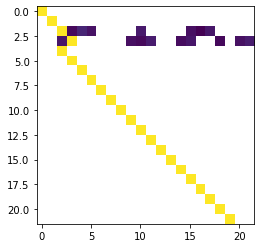

In [267]:
plt.imshow(np.log(A_init))

In [259]:
np.dot(left, right).shape

(22, 20)

In [260]:
A_init

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         2.94902991e-17,  1.82145965e-16, -1.11029079e-17,
    

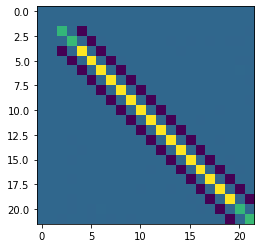

In [83]:
plt.imshow(np.linalg.inv(S.sum(axis=0)))

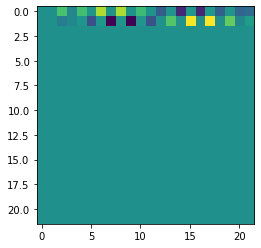

In [77]:

plt.imshow()

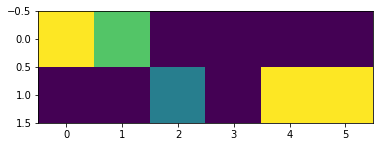

In [87]:
A_block = np.random.standard_normal((2, 6))
plt.imshow(np.clip(A_block, 0, 1))


In [59]:
def subdivide_A(n, p):
    E_1 = np.concatenate([np.zeros((n,n)), np.eye(n), np.zeros((n*(p-1), n))], axis=0).T
    E_2 = np.concatenate([np.zeros((n*p, n)), np.eye(n*p, n*p)], axis=1)
    Res = np.concatenate([np.eye(n, n*(p+1)), np.zeros((n, n*(p+1))), \
                          np.concatenate([np.zeros((n*(p-1), n)), np.eye(n*(p-1), n*p)], axis=1)], axis=0)
    return E_1, E_2, Res

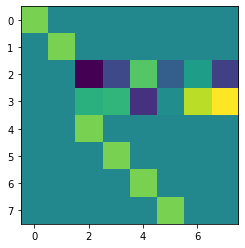

In [63]:
E_1, E_2, Res = subdivide_A(2, 3)
plt.imshow(E_1.T@A_block@E_2 + Res)

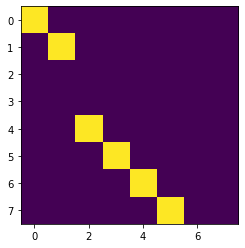

In [61]:
plt.imshow(Res)

In [68]:
print("m step")
E_1, E_2, Res = subdivide_A(n, p)
R = R_k(s_m, s_P)
S = S_k(s_m, s_P)
R = R.sum(axis=0)
S = S.sum(axis=0)

A_block_star = np.linalg.pinv(E_1.T) @ (R - Res@S@E_2.T) @ np.linalg.inv(E_2@S@E_2.T)

m step


ValueError: operands could not be broadcast together with shapes (22,22) (22,20) 

In [70]:
np.linalg.pinv(E_1.T).shape,  np.linalg.inv(E_2@S@E_2.T).shape

((2, 22), (20, 20))

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85
step 86
step 87
step 88
step 89
step 90
step 91
step 92
step 93
step 94
step 95
step 96
step 97
step 98
step 99
step 100
step 101
step 102
step 103
step 104
step 105
step 106
step 107
step 108
step 109
step 110
step 111
step 112
step 113
step 114
step 115
step 116
step 117
step 118
step 119
step 120
step 121
step 122
ste

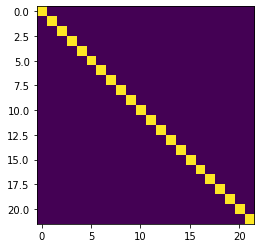

e step
m step
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.09899999999964908
0.04949999999982454
0.04949999999982454
0.04949999999982454
0.04949999999982454
0.04949999999982454
0.04949999999982454
0.04949999999982454
0.04949999999982454
0.04949999999982454
0.0494

<Figure size 432x288 with 0 Axes>

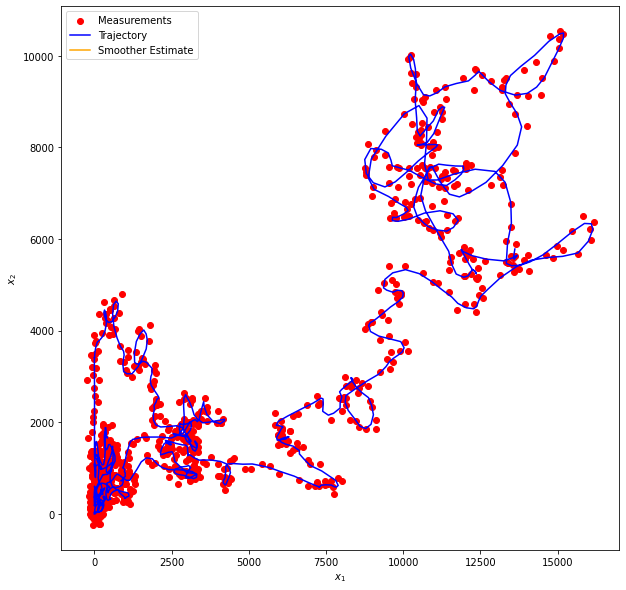

a init


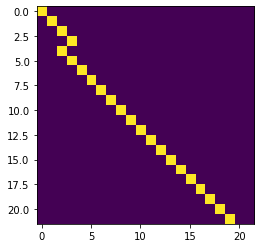

1


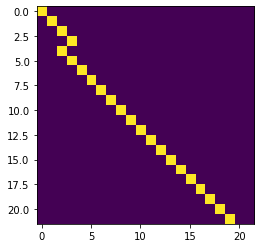

e step
m step


KeyboardInterrupt: 

In [146]:
def R_k(m, P):
    R = np.zeros(P.shape)
    for k in range(1, len(kf_m)):
        mk = m[k][:, np.newaxis]    # column vector m_k^s
        mk1 = m[k-1][:, np.newaxis] # column vector m_{k-1}^s
        Pk = P[k]
        
        R[k] = mk@g(mk1).T + (Pk + mk@mk.T)@G(mk1).T - mk@mk1.T@G(mk1).T
    
    return R
        
def S_k(m, P):
    S = np.zeros(P.shape)
    for k in range(1, len(kf_m)):
        mk = m[k][:, np.newaxis]    # column vector m_k^s
        mk1 = m[k-1][:, np.newaxis] # column vector m_{k-1}^s
        Pk = P[k]
        
        S[k] = g(mk1)@g(mk1).T + g(mk1)@mk.T@G(mk1).T - g(mk1)@mk1.T@G(mk1).T + \
               G(mk1)@mk@g(mk1).T - G(mk1)@mk1@g(mk1).T + G(mk1)@(Pk + mk@mk.T)@G(mk1).T -\
               G(mk1)@mk@mk1.T@G(mk1).T - G(mk1)@mk1@mk.T@G(mk1).T + G(mk1)@mk1@mk1.T@G(mk1).T
      
    return S

def e_step(m_0, P_0, A_init, f, F, Q, H, R):
    print("e step")
    kf_m, kf_P = extended_kalman_filter(m_0, P_0, f, F, Q, H, R, observations)

    s_m, s_P = extended_rts_smoother(kf_m, kf_P, f, F, Q)
    return s_m, s_P

def subdivide_A(n, p):
    E_1 = np.concatenate([np.zeros((n,n)), np.eye(n), np.zeros((n*(p-1), n))], axis=0).T
    E_2 = np.concatenate([np.zeros((n*p, n)), np.eye(n*p, n*p)], axis=1)
    Res = np.concatenate([np.eye(n, n*(p+1)), np.zeros((n, n*(p+1))), \
                          np.concatenate([np.zeros((n*(p-1), n)), np.eye(n*(p-1), n*p)], axis=1)], axis=0)
    return E_1, E_2, Res

def _solve_for_a(q, s1, s2, a, p1, lambda2, max_iter=5000, tol=1e-3, zeroed_index=None, n_eigenmodes=1):
    """Gradient descent to learn a, state-transition matrix

    Parameters
    ----------
    q : ndarray of shape (n_sources, n_sources)
    s1 : ndarray of shape (n_sources, n_sources*order)
    s2 : ndarray of shape (n_sources*order, n_sources*order)
    a : ndarray of shape (n_sources, n_sources*order)
    lambda2 : float
    max_iter : int, default=1000
    tol : float, default=0.01
    zeroed_index : tuple of lists, like ([3, 3, 3], [1, 2, 3]).
        forces these indexes of a to 0.0.

    Notes
    -----
    To learn restricted model for i --> j, pass ([j] * p, list(range(i, m*p, m)))
    as zeroed index.

    Returns
    -------
    a : ndarray of shape (n_sources, n_sources*order)
    changes : list of floats
    """
    if lambda2 == 0:
        try:
            a = linalg.solve(s2, s1.T, assume_a='pos') # s1 * (s2 ** -1)
        except linalg.LinAlgError:
            try:
                a = linalg.solve(s2, s1.T, assume_a='sym') # s1 * (s2 ** -1)
            except linalg.LinAlgError:
                a, *rest = linalg.lstsq(s2, s1.T) # s1 * (s2 ** -1)
        return a.T, None

    eps = np.finfo(s1.dtype).eps
    q = np.diag(q)
    qinv = 1 / q
#     qinv = np.expand_dims(qinv, -1)
    q_inv_sqrt = np.sqrt(qinv)

    d = np.sqrt(np.diag(s2))
#     print(q_inv_sq)
    s2 = s2 / d[:, None]
    s2 = s2 / d[None, :]
    s1 = s1 / d[None, :]
    a = a * d[None, :]

    a = a * q_inv_sqrt
    s1 = s1 * q_inv_sqrt

    h_norm = np.linalg.eigvalsh(s2).max()
    tau_max = 0.99 / h_norm

    _a = np.empty_like(a)
    temp = np.empty_like(a)
    m = a.shape[0]
    p = a.shape[1] // m

    changes = np.zeros(max_iter+1)
    fs = np.zeros(max_iter+1)
    changes[0] = 1
    num = 1
    f_old = -2 * np.einsum('ij,ji->i', a.T, s1).sum() + np.einsum('ij,ji->i', a.T, a.dot(s2)).sum()
    fs[0] = f_old
    temp1 = a.dot(s2)
    for i in range(max_iter):
        if changes[i] < tol or num == 0:
            break
        _a[:] = a
        # Calculate gradient
        grad = temp1
        grad -= s1
        grad *= 2

        # # old implementation of aggregate eigenmodes
        # grad = _take_care(grad, n_eigenmodes)

        # Find opt step-size
        warnings.filterwarnings('error')
        try:
            # tau = 0.5 * (grad * grad).sum() / (np.diag(grad.dot(s2.dot(grad.T))) * qinv.ravel()).sum()
            temp2 = grad.dot(s2.T)
            den = ((temp2 * grad).sum(axis=1)).sum()
            num = (grad * grad).sum()
            tau = 0.5 * num / den
            tau = max(tau, tau_max)
        except Warning:
            raise RuntimeError(f'Q possibly contains negative value {q.min()}')
        warnings.filterwarnings('ignore')

        while True:
            # Forward step
            temp = _a.copy()
            temp -= tau * grad

            # Backward (proximal) step
            for i in range(len(temp)):
                for j in range(temp.shape[1]):
                    a[i, j] = shrink(temp[i, j], lambda2 * tau)

            # #************* make the self history = 0 from lag p1***********
            for k in range(p1, p):
                a.flat[k * m::(p * m + 1)] = 0.0
            # # *************************************************************
            if zeroed_index is not None:
                a[zeroed_index] = 0.0

            "************* make the cross history between eigenmodes = 0 from lag p1***********"
            for l in range(0, m, n_eigenmodes):
                for u in range(n_eigenmodes):
                    for v in range(n_eigenmodes):
                        if v != u:
                            a[l+v, l+u::m] = 0
            "*********************************************************************"

            temp1 = a.dot(s2)
            f_new = -2 * np.einsum('ij,ji->i', a.T, s1).sum() + np.einsum('ij,ji->i', a.T, temp1).sum()
            diff = (a - _a)
            f_new_upper = f_old + (grad * diff).sum() + (diff ** 2).sum() / (2 * tau)
            if f_new < f_new_upper or tau / tau_max < 1e-10:
                break
            else:
                tau /= 2

        num = np.sum(diff ** 2)
        den = np.sum(_a ** 2)
        f_old = f_new
        changes[i+1] = 1 if den == 0 else np.sqrt(num / den)

        fs[i+1] = f_old

    a = a / d[None, :]
    a = a / q_inv_sqrt

    return a, changes


def shrink(x, t):
    print(t)
    if x > t:
        return x - t
    elif x < -t:
        return x + t
    else:
        return 0

left = None
right = None
attempted_A = None
def m_step(m, P):
    global left, right, attempted_A
    print("m step")
    E_1, E_2, Res = subdivide_A(n, p)
    
    R = R_k(m, P)
    S = S_k(m, P)
    R = R.sum(axis=0)
    S = S.sum(axis=0)
    
    s1 = (np.linalg.pinv(E_1.T)@R@E_2.T - np.linalg.pinv(E_1.T)@Res@S@E_2.T)
    s2 = np.linalg.inv(E_2@S@E_2.T)
    
    a_upper = A_init[n:2*n, n:]

    A_block_star, _ = _solve_for_a(Q[n:, n:], s1, s2, a_upper, p, lambda2=0.1)
#     plt.imshow(A_block_star)

#     while (np.abs(np.linalg.eig(Res + E_1.T@A_block_star@E_2)[0]) > 1).any():
    print("renormalizing A with eigs:", np.linalg.eig(Res + E_1.T@A_block_star@E_2)[0])
    eps = 0.0001
    A_block_star = A_block_star / (np.abs(A_block_star).sum(axis=1)[:, np.newaxis] + eps)
    print("corrected A eigs:", np.linalg.eig(Res + E_1.T@A_block_star@E_2)[0])
    attempted_A = Res + E_1.T@A_block_star@E_2
    assert(not (np.abs(np.linalg.eig(Res + E_1.T@A_block_star@E_2)[0]) > (1 + eps)).any())
    
    # return reconstructed A matrix
    return Res + E_1.T@A_block_star@E_2


n = 2
p = 10
pn_coeff = 5
on_coeff = 10000

x_0 = np.random.standard_normal(((p+1)*n, 1))
P_0 = Q = 0.001* np.eye((p+1)*n, (p+1)*n)
P_0[n, n] = pn_coeff
P_0[n+1, n+1] = pn_coeff
P_0[n+2, n+2] = pn_coeff
P_0[n+3, n+3] = pn_coeff
P_0[n+4, n+4] = pn_coeff
P_0[n+5, n+5] = pn_coeff

Q[n, n] = pn_coeff
Q[n+1, n+1] = pn_coeff
Q[n+2, n+2] = pn_coeff
Q[n+3, n+3] = pn_coeff
Q[n+4, n+4] = pn_coeff
Q[n+5, n+5] = pn_coeff



H = np.zeros((2, (p+1)*n))
H[0, 0] = 1
H[1, 1] = 1

R = on_coeff*np.eye(n)

random_state = RandomState(15)
steps = 1000

states, observations = generate_nonlinear_ssm(x_0, P_0, f, Q, H, R, steps, random_state)

m_0 = np.random.standard_normal(((p+1)*n, 1))
# P_0 = np.eye((p+1)*n, (p+1)*n)
A_init = np.eye((n*(p+1)))*0.001
# A_init[2,2]=0
# A_init[3,3]=0
# A_init[1,2] = 1
# A_init[3,5] = 1
# A_init[2,7] = 1
# A_init[0,1] = 1

# A_init = np.random.randint(0,2,(22,22))

for niter in range(10):
    print(niter)
    plt.imshow(A_init)
    plt.show()
    def f_hat(x):
        return A_init@g(x)
    
    def F_hat(x):
        return A_init@G(x)
    
    s_m, s_P = e_step(m_0, P_0, A_init, f_hat, F_hat, Q, H, R)
    m_0, P_0 = s_m[0][:, np.newaxis], s_P[0]
    A_init = m_step(s_m, s_P)
    
    plt.figure()
    plot_car_trajectory(observations, states, "Trajectory", s_m, "Smoother Estimate")
    plt.show()
    print("a init")
    plt.imshow(A_init)
    plt.show()

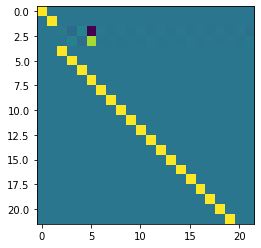

In [135]:
plt.imshow(A_init)

In [133]:
np.abs(np.linalg.eig(attempted_A)[0]) > 1.0001

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [ ]:
E_1, E_2, Res = subdivide_A(n, p)
    
R = R_k(s_m, s_P)
S = S_k(s_m, s_P)
R = R.sum(axis=0)
S = S.sum(axis=0)

s1 = (np.linalg.pinv(E_1.T)@R@E_2.T - np.linalg.pinv(E_1.T)@Res@S@E_2.T)
s2 = np.linalg.inv(E_2@S@E_2.T)

In [112]:
not True

False

In [79]:
import warnings

In [135]:
q_upper = Q[n:n+n*2]
a_upper = A_init[n:2*n, n:]

a, changes = _solve_for_a(Q[n:, n:], s1, s2, a_upper, p, lambda2=0.01)
a

array([[79826598.45264079, 11184793.29661302, 89684696.83771399,
        12715739.6501169 ,  4977693.9633109 ,   642694.62296302,
         5196659.26480229,   670008.47123183,  5259179.66779131,
          679802.71851896,  5203701.75377902,   676012.84296962,
         5045645.49367812,   665562.88286427,  4800928.82032273,
          654399.20335837,  4487572.56966924,   644145.39832202,
         4105584.08757695,   631586.93449075],
       [11186720.15549481, 55913653.22596776, 11977185.12751477,
        63287748.40267473,   609820.09988128,  3622097.761417  ,
          641313.93092756,  3765163.04717727,   660095.13557505,
         3783469.97044405,   669944.22371765,  3711300.08939541,
          672256.7585209 ,  3563000.8669345 ,   662340.84307249,
         3352792.78892674,   637073.63643284,  3094347.35387411,
          593763.00505162,  2789883.7733472 ]])

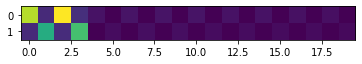

In [132]:
plt.imshow(a)

In [111]:
changes

array([1.00000000e+00, 5.13054201e+07, 7.25448110e-01, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

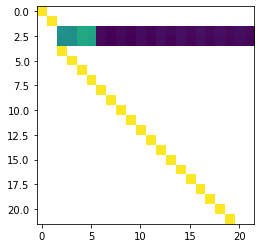

In [146]:
plt.imshow(np.log(A_init))

In [141]:
np.linalg.eig(A_init)

(array([ 2.49499842e+05+0.j        ,  1.03922048e-01+0.j        ,
         7.87999383e-02+0.06721512j,  7.87999383e-02-0.06721512j,
         1.66928140e-02+0.10142997j,  1.66928140e-02-0.10142997j,
        -5.18405696e-02+0.08789994j, -5.18405696e-02-0.08789994j,
        -9.56128902e-02+0.03442287j, -9.56128902e-02-0.03442287j,
         7.40495021e-12+0.j        ,  2.49500000e+05+0.j        ,
        -2.13682977e-02+0.j        , -1.55567222e-02+0.01496353j,
        -1.55567222e-02-0.01496353j, -4.99393298e-04+0.02200059j,
        -4.99393298e-04-0.02200059j,  1.55573058e-02+0.01596173j,
         1.55573058e-02-0.01596173j,  2.23659170e-02+0.j        ,
         1.00000000e+00+0.j        ,  1.00000000e+00+0.j        ]),
 array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00

In [142]:
d = np.empty_like(np.eye(5))

In [143]:
d[:] = np.eye(5)

In [144]:
d

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])